# Problem setting: Sine Wave Prediction.

This jupyter notebook demonstrates the function of **Encoder/Decoder based on LSTM**.

In this demonstration, the training dataset is generated as follows.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)


In [4]:
def generate_sin(amp=0.5, sampling_freq=8000, freq=440, sec=5, extract_n=100):
    sin_list = []
    for n in np.arange(sampling_freq * sec):
        sin = amp * np.sin(2.0 * np.pi * freq * n / sampling_freq)
        sin_list.append(sin)
        if len(sin_list) > extract_n:
            break
    return np.array(sin_list[:extract_n])


In [5]:
generate_sin(freq=200).shape

(100,)

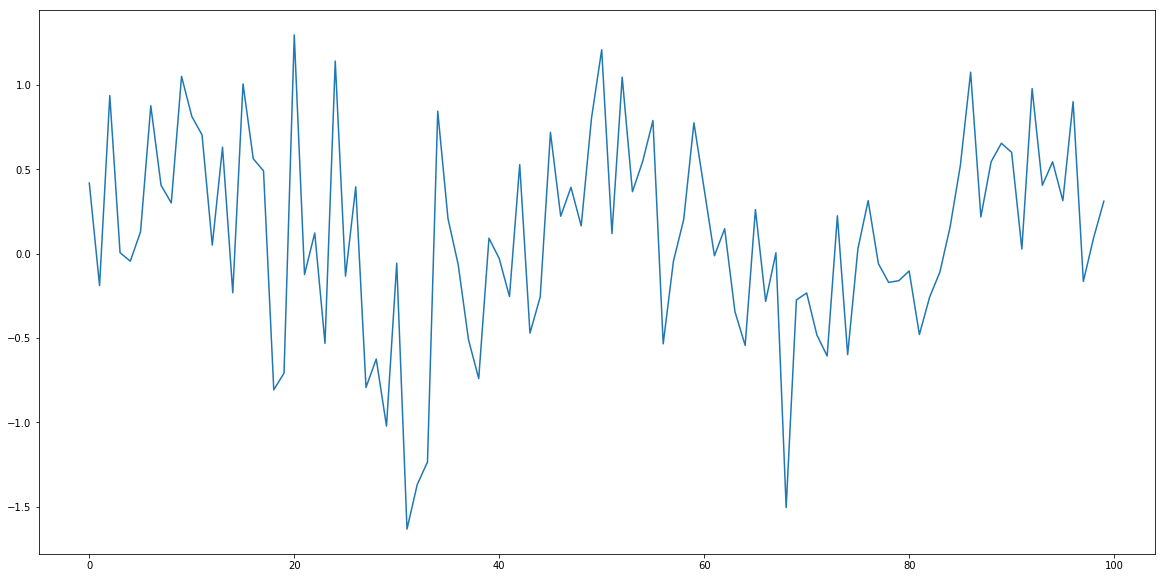

In [4]:
fig = plt.figure(figsize=(20, 10))
plt.plot(generate_sin(freq=200) + np.random.normal(loc=0.0, scale=0.5, size=100))
plt.show()

In [5]:
# The number of sampled data.
sample_n = 1000
# The length of one cycle.
cycle_len = 20
# The number of features.
feature_n = 10

# The list of observed data points.
observed_arr_list = []
# The list of objective data.
target_arr_list = []

label_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
test_size = 0.3

for i in range(sample_n):
    f_list = []
    t_list = []
    label_n = np.random.randint(low=0, high=len(label_list))

    for j in range(feature_n):
        sin_arr = generate_sin(freq=int(label_list[label_n]), extract_n=cycle_len)
        noise_arr = np.random.normal(loc=0.0, scale=1.5, size=cycle_len)
        sin_arr += noise_arr
        f_arr = sin_arr[:int(sin_arr.shape[0] * (1 - test_size))]
        t_arr = sin_arr[int(sin_arr.shape[0] * (1 - test_size)):]
        f_list.append(f_arr)
        t_list.append(t_arr)

    observed_arr_list.append(f_list)
    target_arr_list.append(t_list)

observed_arr = np.array(observed_arr_list)
#observed_arr = observed_arr[:, 0, :, :]
#observed_arr = (observed_arr - observed_arr.mean()) / observed_arr.std()
target_arr = np.array(target_arr_list).astype(np.float64)
target_arr = target_arr.sum(axis=1)
observed_arr = (observed_arr - observed_arr.mean()) / observed_arr.std()
target_arr = (target_arr - target_arr.mean()) / target_arr.std()

from pydbm.activation.logistic_function import LogisticFunction
observed_arr = LogisticFunction().activate(observed_arr)
target_arr = observed_arr.copy()

observed_arr.shape, target_arr.shape

((1000, 10, 14), (1000, 10, 14))

All Sine waves have been added randomly generated gussain signal noise.

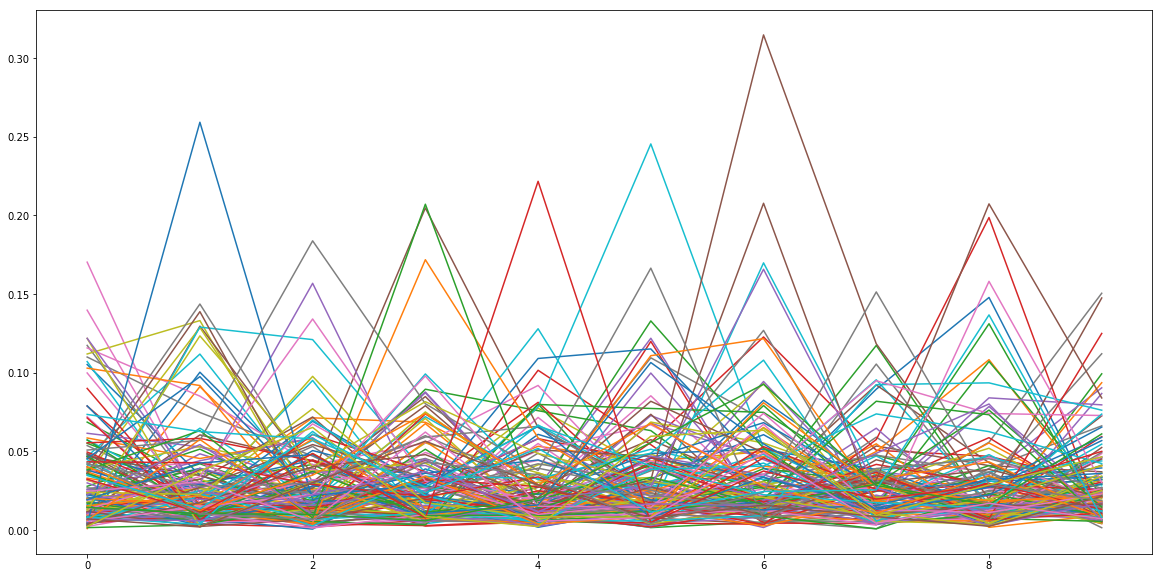

In [6]:
fig = plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(observed_arr[i])
plt.show();plt.close()

## Problem solution: Encoder/Decoder based on LSTM.

In [7]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Polymorphism.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as DecoderGraph

# Loss function.
from pydbm.loss.mean_squared_error import MeanSquaredError
# SGD as a Loss function.
from pydbm.optimization.optparams.sgd import SGD
# Adam as a Loss function.
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
# Verification.
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Polymorphism.
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstm_model import LSTMModel as Decoder
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# Encoder/Decoder
from pydbm.rnn.encoder_decoder_controller import EncoderDecoderController

/usr/local/bin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Use importlib.util.find_spec() instead.
  


In [8]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=200,
    output_neuron_count=1
)

In [9]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = TanhFunction()
decoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=200,
    hidden_neuron_count=200,
    output_neuron_count=observed_arr.shape[-1]
)

In [10]:
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=observed_arr.shape[1],
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [11]:
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # The length of sequences.
    seq_len=observed_arr.shape[1],
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=observed_arr.shape[1],
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [12]:
encoder_decoder_controller = EncoderDecoderController(
    encoder=encoder,
    decoder=decoder,
    epochs=100,
    batch_size=100,
    learning_rate=1e-05,
    learning_attenuate_rate=0.1,
    attenuate_epoch=50,
    test_size_rate=0.3,
    computable_loss=MeanSquaredError(),
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [13]:
# Learning.
encoder_decoder_controller.learn(observed_arr, target_arr)

Epoch: 1
Loss: 
Training: 0.0473645522048 Test: 0.0597425938449
Epoch: 2
Loss: 
Training: 0.0620616509513 Test: 0.0460285416465
Epoch: 3
Loss: 
Training: 0.0548489752147 Test: 0.0617137762635
Epoch: 4
Loss: 
Training: 0.0538951548187 Test: 0.0640255942836
Epoch: 5
Loss: 
Training: 0.0483984448848 Test: 0.0588578142049
Epoch: 6
Loss: 
Training: 0.0642265609873 Test: 0.0607227704858
Epoch: 7
Loss: 
Training: 0.0647628494365 Test: 0.0613879452891
Epoch: 8
Loss: 
Training: 0.0518549944038 Test: 0.0576558253453
Epoch: 9
Loss: 
Training: 0.0495138462491 Test: 0.0612997940437
Epoch: 10
Loss: 
Training: 0.0538976838273 Test: 0.065145541579
Epoch: 11
Loss: 
Training: 0.052217373988 Test: 0.0610625377557
Rolling mean of Loss (Window is 10): 
Training: 0.055082471297830025 Test: 0.05965801969863541
Epoch: 12
Loss: 
Training: 0.0501479964886 Test: 0.0592662980834
Rolling mean of Loss (Window is 10): 
Training: 0.055567753476151595 Test: 0.059790014089719026
Epoch: 13
Loss: 
Training: 0.05274485593

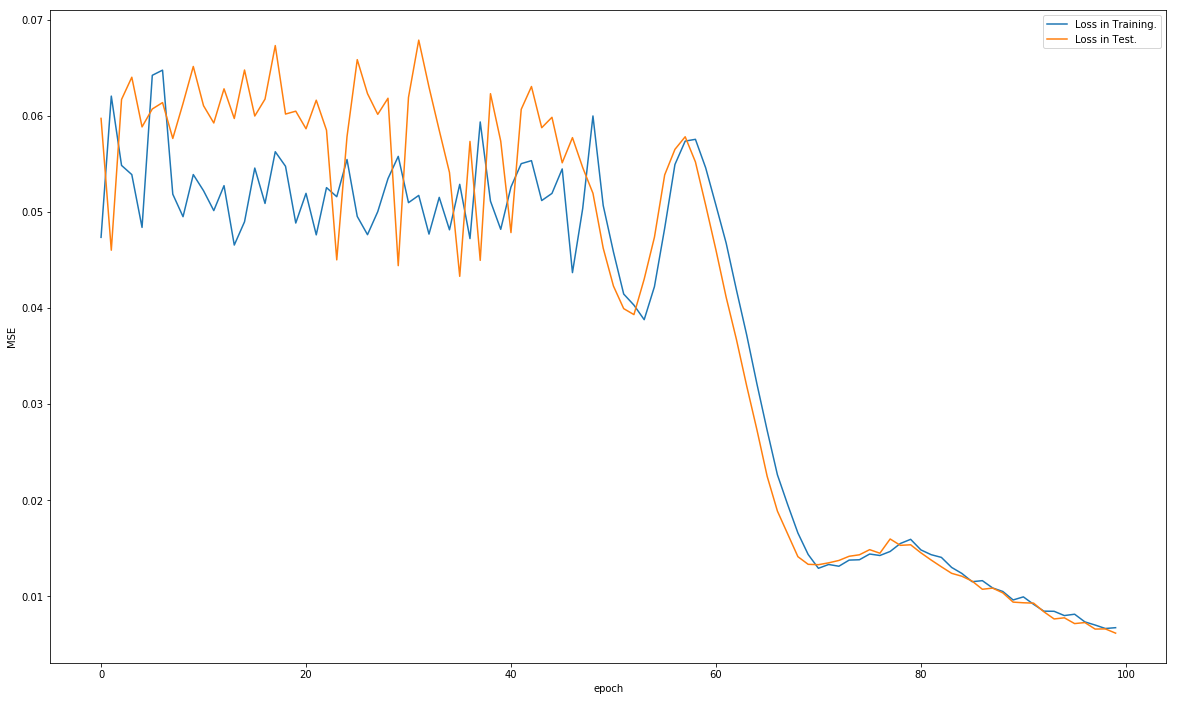

In [14]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [15]:
encoder_decoder_controller.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
90,0.009953,0.009339
91,0.009177,0.009303
92,0.008467,0.008404
93,0.008451,0.007656
94,0.008007,0.007774
95,0.008148,0.007173
96,0.007350,0.007281
97,0.007024,0.006603
98,0.006663,0.006620
99,0.006746,0.006178


In [16]:
# The list of observed data points.
test_observed_arr_list = []
# The list of objective data.
test_target_arr_list = []

label_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for i in range(sample_n):
    f_list = []
    t_list = []
    label_n = np.random.randint(low=0, high=len(label_list))

    for j in range(feature_n):
        sin_arr = generate_sin(freq=int(label_list[label_n]), extract_n=cycle_len)
        noise_arr = np.random.normal(loc=0.0, scale=1.5, size=cycle_len)
        sin_arr += noise_arr
        f_arr = sin_arr[:int(sin_arr.shape[0] * (1 - test_size))]
        t_arr = sin_arr[int(sin_arr.shape[0] * (1 - test_size)):]
        f_list.append(f_arr)
        t_list.append(t_arr)

    observed_arr_list.append(f_list)
    target_arr_list.append(t_list)

test_observed_arr = np.array(observed_arr_list)
from pydbm.activation.logistic_function import LogisticFunction
test_observed_arr = LogisticFunction().activate(test_observed_arr)

#######
test_target_arr = observed_arr.copy()
#######
test_observed_arr.shape, test_target_arr.shape

((2000, 10, 14), (1000, 10, 14))

In [17]:
#lstm_model.inference(observed_arr[:20, :, :])[:3, :]
#arr = np.random.normal(loc=0.0, scale=0.5, size=observed_arr.shape)
#arr = np.random.uniform(low=0.0, high=1.0, size=observed_arr.shape)
encoder_decoder_controller.inference(test_observed_arr[3:6, :, :])

array([[  4.54124765e-01,   7.74996698e-01,   5.76191275e-01,
          5.06355144e-01,   8.72463782e-01,   5.85016572e-01,
          7.30311314e-01,   5.11595053e-01,   3.85359226e-01,
          4.13617870e-01,   1.78528977e-01,   5.39655923e-01,
          4.10645954e-01,   8.63035597e-01,   5.37502158e-01,
          5.52055956e-01,   6.45062305e-01,   6.37675314e-01,
          2.04600662e-01,   4.99338045e-01,   2.21104201e-01,
          8.48974755e-01,   2.67156940e-01,   4.93189931e-01,
          3.24458398e-01,   6.34032278e-01,   3.41032784e-01,
          2.08514818e-01,   3.79877716e-01,   7.13927461e-01,
          8.10942635e-01,   4.30361449e-01,   3.03493715e-01,
          6.09681710e-01,   4.32057389e-01,   5.39341782e-01,
          5.60738259e-01,   4.55194631e-01,   5.29116447e-01,
          8.79421887e-01,   3.91081612e-01,   2.54351787e-01,
          5.75122135e-01,   3.14462260e-01,   4.26832135e-01,
          4.72689333e-01,   5.96151736e-01,   2.66040471e-01,
        

In [19]:
reconstruction_error_arr = encoder_decoder_controller.get_reconstruction_error()
reconstruction_error_arr

array([ 0.00589039,  0.00608681,  0.00538968])